<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов


### Цель работы:
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет на основе исторических данных о поведении клиентов и расторжении договоров с банком.





### Подготовка данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle
import numpy as np
from sklearn.metrics import precision_score, recall_score
df = pd.read_csv('/content/drive/MyDrive/Churn.csv')

In [ ]:
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [ ]:
df.isna().sum()/df.count()

RowNumber          0.000000
CustomerId         0.000000
Surname            0.000000
CreditScore        0.000000
Geography          0.000000
Gender             0.000000
Age                0.000000
Tenure             0.099989
Balance            0.000000
NumOfProducts      0.000000
HasCrCard          0.000000
IsActiveMember     0.000000
EstimatedSalary    0.000000
Exited             0.000000
dtype: float64

Обнаружены пропуски в столбце Tenure. Доля пропусков меньше одного процента, поэтому удалим объеты их содержащие.

In [ ]:
df[df['Tenure'].isna() == True] = df['Tenure'].median()

Проверим датафрейм на наличие явных дубликатов.

In [ ]:
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999     True
Length: 10000, dtype: bool

Обнаружились явные дубликаты, удалим их.

In [ ]:
df = df.drop_duplicates()

Проверим целевой признак на наличие аномальных значений.

In [ ]:
df.Exited.unique()

array([1, 0, 5])

Класс Exited - бинарный. Ничего кроме нулей и единиц в нем быть не должно, поэтому объекты с пятерками в целевом признаке явно аномальные. Удалим их.

In [ ]:
df = df.query('Exited == 1 or Exited == 0')

Для обучения моделям не понадобятся столбцы с id, фамилиями и дополнительными индексами, поэтому их удалим.

In [ ]:
df = df.drop(['Surname', 'CustomerId', 'RowNumber'], axis = 1)

In [ ]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

Преобразуем категориальные признаки. Так как поставлена задача классификации, то будем использовать OHE - кодирование.




In [ ]:
df = pd.get_dummies(df, drop_first=True)

Разделим выборки на тренировочную, валидационную и тестовую

In [ ]:
target = df['Exited']
features = df.drop('Exited', axis = 1)
features_remaining, features_test, target_remaining, target_test = train_test_split(features,
                                                                                    target,
                                                                                    test_size=0.2,
                                                                                    random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(features_remaining,
                                                                              target_remaining,
                                                                              test_size=0.25,
                                                                              random_state=12345)


Стандартизируем количественные признаки

In [ ]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'NumOfProducts']
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

## Исследование задачи

Исследуем баланс классов

In [ ]:
df['Exited'].sum()/df['Exited'].count()

0.2039379606203938

Замечен дисбаланс классов. Сначала изучим модели без учета дисбаланса.

###1. Лес решений

Определим максимальную высоту деревьев. Точность модели будем определять по метрике F1.

In [ ]:
max_score = 0
best_depth = 0
for depth in range(10,51,1):
  forest = RandomForestClassifier(n_estimators=20,
                                  max_depth=depth,
                                  random_state=12345)
  forest.fit(features_train, target_train)
  predicted_valid = forest.predict(features_valid)
  score = f1_score(target_valid, predicted_valid)
  if score > max_score:
    max_score = score
    best_depth = depth

print('f1:', max_score, '|', best_depth)



f1: 0.5570934256055363 | 14


Подберем оптимальное количество деревьев

In [ ]:
max_score = 0
best_est = 0
for est in range(10,100,1):
  forest = RandomForestClassifier(n_estimators=est,
                                  max_depth=14,
                                  random_state=12345)
  forest.fit(features_train, target_train)
  predicted_valid = forest.predict(features_valid)
  score = f1_score(target_valid, predicted_valid)
  if score > max_score:
    max_score = score
    best_est = est

print('f1:', max_score, '|', best_est)


f1: 0.5629370629370629 | 37


Вычислим также AUC-ROC данной модели:

In [ ]:
forest = RandomForestClassifier(n_estimators=37,
                                  max_depth=14,
                                  random_state=12345)
forest.fit(features_train, target_train)
predicted_valid = forest.predict_proba(features_valid)
predicted_valid_one = predicted_valid[:,1]
auc = roc_auc_score(target_valid, predicted_valid_one)
print('AUC-ROC:',auc)

AUC-ROC: 0.8241778816480754


###2. Логистическая регрессия

In [ ]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

f1 = f1_score(target_valid, predicted_valid)
print('f1:',f1)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC:',auc_roc)

f1: 0.3004115226337448
AUC-ROC: 0.772597434855259


Как показывает результат вычисления, обе модели плохо выдерживают проверку метрикой F1. Метрика AUC-ROC показывает результат лучше, но этого все равно не достаточно для того, чтобы применять эти модели на практике.

## Борьба с дисбалансом

Теперь сбалансируем модели несколькими способами. Первый способ - добавление параметра "balanced" для взвешивания классов.

In [ ]:
forest = RandomForestClassifier(n_estimators=37,
                                  max_depth=14,
                                  random_state=12345,
                                class_weight = 'balanced')
forest.fit(features_train, target_train)
predicted_valid = forest.predict_proba(features_valid)
predicted_valid_one = predicted_valid[:,1]
auc = roc_auc_score(target_valid, predicted_valid_one)
print('AUC-ROC:',auc)
predicted_valid = forest.predict(features_valid)
print('f1:', f1_score(target_valid, predicted_valid))




AUC-ROC: 0.8348452859443917
f1: 0.5546218487394958


In [ ]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight = 'balanced')
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

f1 = f1_score(target_valid, predicted_valid)
print('f1:',f1)
auc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC:',auc)

f1: 0.49506903353057197
AUC-ROC: 0.7747783347634317


Можно заметить знаметное увеличение метрики f1 у логистической регрессии. Метрика леса решений осталась почти той же. Использовать данный способ балансировки - не луйший вариант.

Следующий метод балансировки - увеличение выборки.

In [ ]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(features_upsampled,
                                                   target_upsampled,
                                                   random_state=12345)

    return features_upsampled, target_upsampled

repeat = round((df['Exited'].count() - df['Exited'].sum())/df['Exited'].sum())
features_upsampled, target_upsampled = upsample(features_train, target_train, repeat)

Теперь обучим модели на увеличенных выборках.

In [ ]:
forest = RandomForestClassifier(n_estimators=37,
                                  max_depth=14,
                                  random_state=12345)
forest.fit(features_upsampled, target_upsampled)
predicted_valid = forest.predict_proba(features_valid)
predicted_valid_one = predicted_valid[:,1]
auc = roc_auc_score(target_valid, predicted_valid_one)
print('AUC-ROC:',auc_roc)
predicted_valid = forest.predict(features_valid)
print('f1:', f1_score(target_valid, predicted_valid))

AUC-ROC: 0.772597434855259
f1: 0.6048502139800285


In [ ]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)

predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

f1 = f1_score(target_valid, predicted_valid)
print('f1:',f1)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC:',auc_roc)

f1: 0.4956605593056895
AUC-ROC: 0.7748272591789732


F1 для леса решений перешагнула порог в 0.59, а значит ее можно будет использовать на тестовой выборке. Для логистической регрессии значение метрики f1 почти не изменилось.

Третий метод балансировки - уменьшение выборки:

In [ ]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)


Обучим модели на уменьшенных выборках.

In [ ]:
forest = RandomForestClassifier(n_estimators=37,
                                  max_depth=14,
                                  random_state=12345)
forest.fit(features_downsampled, target_downsampled)
predicted_valid = forest.predict_proba(features_valid)
predicted_valid_one = predicted_valid[:,1]
auc = roc_auc_score(target_valid, predicted_valid_one)
print('AUC-ROC:',auc_roc)
predicted_valid = forest.predict(features_valid)
print('f1:', f1_score(target_valid, predicted_valid))

AUC-ROC: 0.7748272591789732
f1: 0.5655471289274105


In [ ]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)

predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

f1 = f1_score(target_valid, predicted_valid)
print('f1:',f1)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC:',auc_roc)

f1: 0.5
AUC-ROC: 0.7754858570804919


Данный метод оказался еще хуже предыдущего: f1 для леса скатилась ниже пороговой отметки в 0.59, а прирост к метрике f1 логистической регрессии всего около 0.05

Итого, самый лучший результат показал лес решений, сбалансированный методом увеличения выборки.

## Тестирование модели

Протестируем лучшую модель на тестовой выборке.

In [ ]:
forest = RandomForestClassifier(n_estimators=37,
                                  max_depth=14,
                                  random_state=12345)
forest.fit(features_upsampled, target_upsampled)
predicted_valid = forest.predict_proba(features_test)
predicted_valid_one = predicted_valid[:,1]
auc = roc_auc_score(target_test, predicted_valid_one)
print('AUC-ROC:',auc_roc)
predicted_valid = forest.predict(features_test)
print('f1:', f1_score(target_test, predicted_valid))

AUC-ROC: 0.7754858570804919
f1: 0.5914718019257221


Метрика f1 на тестовой выборке составила 0.591, что удовлетворяет условию задачи.

Построим для данной модели ROC кривую

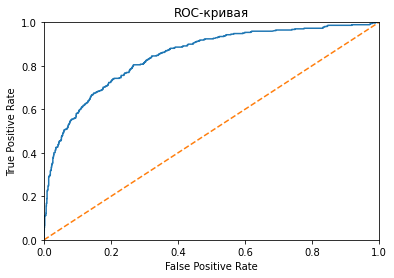

In [ ]:
probabilities_test = forest.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title("ROC-кривая")
plt.show()

ROC-кривая наглядно демонстрирует отличие итоговой модели от случайной: график зависимости TPR от FPR заметно выше линейной фунции константной модели, что подтверждает рание вычисления AUC-ROC: 0.775 > 0.5.

###Вывод: В ходе проделанной работы были изучены данные, содержащиеся в датасете, проведена их предобработка, экспериментальным путем найдена наиболее точная модель, тестирование которой на тестовой выборке дало показатели 0.59 для F1-score и 0.775 для AUC-ROC.